In [1]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Pull FRED Data
FRED_KEY = '02b2c2d2bbf883773e270d39679071c9'
FREDurl = 'https://api.stlouisfed.org/fred/series/observations'



param1 = {
    'series_id': 'VMT',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param1)
data = response.json()
observations = data['observations']
df1 = pd.DataFrame(observations)
df1 = df1.rename(columns={"date": "ds","value": "VMT"})
df1 = df1[['ds', 'VMT']]




param2 = {
    'series_id': 'TOTALSA',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param2)
data = response.json()
observations = data['observations']
df2 = pd.DataFrame(observations)
df2 = df2.rename(columns={"date": "ds","value": "TOTALVS"})
df2 = df2[['ds', 'TOTALVS']]



param3 = {
    'series_id': 'MRTSSM44112USN',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param3)
data = response.json()
observations = data['observations']
df3 = pd.DataFrame(observations)
df3 = df3.rename(columns={"date": "ds","value": "USEDVS"})
df3 = df3[['ds', 'USEDVS']]

param4 = {
    'series_id': 'RSGASS',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param4)
data = response.json()
observations = data['observations']
df7 = pd.DataFrame(observations)
df7 = df7.rename(columns={"date": "ds","value": "SALES"})
df7 = df7[['ds', 'SALES']]


# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'


# Initialize parameters
Date = "2010-01-01"
End = None
# API endpoints 
# EIA endpoints


url_WTI = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'   
urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'   
totalurl = 'https://api.eia.gov/v2/total-energy/data/'

# Parameters

WTI = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RWTC",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

Gas = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "EER_EPMRU_PF4_RGC_DPG",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}



response2 = requests.get(url_WTI, params=WTI)
data2 = response2.json()
df6 = pd.DataFrame(data2['response']['data'])
df6 = df6[['period', 'value']]
df6.rename(columns={'value': 'WTI'}, inplace=True)
df6.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(urlPrice, params=Gas)
data2 = response2.json()
df8 = pd.DataFrame(data2['response']['data'])
df8 = df8[['period', 'value']]
df8.rename(columns={'value': 'Gas Price'}, inplace=True)
df8.rename(columns={'period': 'ds'}, inplace=True)


for df in [df1, df2, df3, df6, df7, df8]:
    df['ds'] = pd.to_datetime(df['ds']).dt.to_period('M').dt.to_timestamp()
df_merged = df6
df_merged = pd.merge(df_merged, df8, on='ds', how='outer')
df_merged = pd.merge(df_merged, df1, on='ds', how='outer')
df_merged = pd.merge(df_merged, df2, on='ds', how='outer')
df_merged = pd.merge(df_merged, df3, on='ds', how='outer')
df_merged = pd.merge(df_merged, df7, on='ds', how='outer')



print(df_merged.tail(20))

df_merged.to_pickle("Gasoline.pkl")

            ds    WTI Gas Price     VMT TOTALVS   USEDVS    SALES
574 2023-11-01  77.69     2.094  260292  15.939  10710.0  53661.0
575 2023-12-01   71.9     2.019  258680  16.385   9995.0  52958.0
576 2024-01-01  74.15     2.146  246434  15.536  10522.0  51918.0
577 2024-02-01  77.25     2.325  241002  16.177  11947.0  52755.0
578 2024-03-01  81.28     2.545  274585  16.136  12615.0  53760.0
579 2024-04-01  85.35     2.595  273208  16.529  12342.0  54570.0
580 2024-05-01  80.02     2.385  292503  16.309  12504.0  53456.0
581 2024-06-01  79.77     2.275  283036  15.433  11542.0  52260.0
582 2024-07-01   81.8     2.373  291010  16.347  12191.0  52740.0
583 2024-08-01  76.68     2.301  292096  15.638  12485.0  52031.0
584 2024-09-01  70.24     1.981  272896  16.275  11460.0  51363.0
585 2024-10-01  71.99     2.023  288167  16.581  11570.0  51326.0
586 2024-11-01  69.95      1.95  261116   17.15  10956.0  51388.0
587 2024-12-01  70.12     1.936  262998  17.323  10859.0  52398.0
588 2025-0

In [3]:
# Approximate current month pricing data
df = pd.read_pickle("Gasoline.pkl")
df['ds'] = pd.to_datetime(df['ds'])


# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'

urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/' 
# Initialize parameters
Date = "2025-01-01"
End = None
# API endpoints 


Gas = {
    "api_key": EIA_KEY, # API key
    "frequency": "daily", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "EER_EPMRU_PF4_RGC_DPG",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

response = requests.get(urlPrice, params=Gas)
data = response.json()
dfdaily = pd.DataFrame(data['response']['data'])
dfdaily = dfdaily[['period', 'value']]
dfdaily.rename(columns={'value': 'Gas Price'}, inplace=True)
dfdaily.rename(columns={'period': 'ds'}, inplace=True)



# Filter last 30 days and compute average
# Ensure 'date' is datetime
dfdaily['date'] = pd.to_datetime(dfdaily['ds'])
dfdaily['Gas Price'] = pd.to_numeric(dfdaily['Gas Price'], errors='coerce')

# Filter past 30 days
today = datetime.today()
start_date = today - timedelta(days=30)
last_month_data = dfdaily[dfdaily['date'] >= start_date]

# Compute average gas price
gas_avg = last_month_data['Gas Price'].mean()


# === Step 1: Get current month start ===
last_reported_month = df['ds'].max()
next_month_start = last_reported_month + relativedelta(months=1)




# === Step 2: Check if row exists for current month ===
if next_month_start not in df['ds'].values:
    
    # === Step 3: Get 30-day average prices from yfinance ===
    today = datetime.today()
    start_date = today - timedelta(days=30)

    wti = yf.download("CL=F", start=start_date, end=today)['Close'].dropna()
    wti_avg = wti.mean().item()

    # === Step 4: Create new row ===
    new_row = {
        'ds': next_month_start,
        'WTI': wti_avg,
        'Gas Price': gas_avg,
        # Fill other columns with NaN
        'USEDVS': None,
        'TOTALVS': None,
        'VMT': None,
        'GASSALES': None,
    }

    # === Step 5: Append to DataFrame ===
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df['month_num'] = df['ds'].dt.month


df.to_pickle("Gasoline1.pkl")

print(df.tail(20))



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

            ds        WTI Gas Price     VMT TOTALVS   USEDVS    SALES  \
575 2023-12-01       71.9     2.019  258680  16.385   9995.0  52958.0   
576 2024-01-01      74.15     2.146  246434  15.536  10522.0  51918.0   
577 2024-02-01      77.25     2.325  241002  16.177  11947.0  52755.0   
578 2024-03-01      81.28     2.545  274585  16.136  12615.0  53760.0   
579 2024-04-01      85.35     2.595  273208  16.529  12342.0  54570.0   
580 2024-05-01      80.02     2.385  292503  16.309  12504.0  53456.0   
581 2024-06-01      79.77     2.275  283036  15.433  11542.0  52260.0   
582 2024-07-01       81.8     2.373  291010  16.347  12191.0  52740.0   
583 2024-08-01      76.68     2.301  292096  15.638  12485.0  52031.0   
584 2024-09-01      70.24     1.981  272896  16.275  11460.0  51363.0   
585 2024-10-01      71.99     2.023  288167  16.581  11570.0  51326.0   
586 2024-11-01      69.95      1.95  261116   17.15  10956.0  51388.0   
587 2024-12-01      70.12     1.936  262998  17.323

In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'VMT'
EXOG_COLS = ['WTI', 'Gas Price']
df = pd.read_pickle("Gasoline1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))

df_full = df

#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      3755.22
RMSE (Root Mean Squared Error): 4500.71
MAPE (Mean Absolute % Error):   1.38%

=== Final df with historical + forecasted values ===
        ds          VMT
2024-12-01 262998.00000
2025-01-01 251206.00000
2025-02-01 237431.00000
2025-03-01 277835.00000
2025-04-01 273714.65625
2025-05-01 288083.06250
2025-06-01 284831.53125
2025-07-01 290378.81250

=== Best Parameters Found ===
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'TOTALVS'
EXOG_COLS = ['WTI', 'Gas Price']
df = pd.read_pickle("Gasoline1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=300,
    max_depth=2,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))

if TARGET_COL not in df_full.columns:
    df_full = pd.merge(df_full, df, on='ds', how='outer')
else:
    df_full.set_index('ds', inplace=True)
    df.set_index('ds', inplace=True)
    df_full.update(df[[TARGET_COL]])
    df_full.reset_index(inplace=True)

#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      0.53
RMSE (Root Mean Squared Error): 0.67
MAPE (Mean Absolute % Error):   3.26%

=== Final df with historical + forecasted values ===
        ds   TOTALVS
2024-12-01 17.323000
2025-01-01 16.026000
2025-02-01 16.397000
2025-03-01 18.281000
2025-04-01 17.741000
2025-05-01 16.052000
2025-06-01 15.777000
2025-07-01 16.201349

=== Best Parameters Found ===
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.6}


In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'USEDVS'
EXOG_COLS = ['WTI', 'Gas Price']
df = pd.read_pickle("Gasoline1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))


if TARGET_COL not in df_full.columns:
    df_full = pd.merge(df_full, df, on='ds', how='outer')
else:
    df_full.set_index('ds', inplace=True)
    df.set_index('ds', inplace=True)
    df_full.update(df[[TARGET_COL]])
    df_full.reset_index(inplace=True)

#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      539.10
RMSE (Root Mean Squared Error): 731.74
MAPE (Mean Absolute % Error):   4.47%

=== Final df with historical + forecasted values ===
        ds       USEDVS
2024-12-01 10859.000000
2025-01-01 10897.000000
2025-02-01 11040.000000
2025-03-01 13986.000000
2025-04-01 13296.000000
2025-05-01 13177.790039
2025-06-01 13101.368164
2025-07-01 13029.950195

=== Best Parameters Found ===
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.6}


In [7]:
df = pd.read_pickle("Gasoline1.pkl")
df = df[['ds', 'SALES']].copy()

if 'SALES' not in df_full.columns:
    df_full = pd.merge(df_full, df, on='ds', how='outer')
else:
    df_full.set_index('ds', inplace=True)
    df.set_index('ds', inplace=True)
    df_full.update(df[['SALES']])
    df_full.reset_index(inplace=True)


df_full = df_full[['ds', 'VMT', 'USEDVS', 'TOTALVS', 'SALES']].copy()


# Check if last row (excluding 'ds') is all NaN
if not df_full.iloc[-1].drop(labels='ds').isna().all():
    next_date = df_full['ds'].max() + relativedelta(months=1)
    new_row = {col: pd.NA for col in df_full.columns}
    new_row['ds'] = next_date
    df_full = pd.concat([df_full, pd.DataFrame([new_row])], ignore_index=True)

print(df_full.tail())

            ds           VMT        USEDVS    TOTALVS    SALES
591 2025-04-01  273714.65625  13296.000000  17.741000  50785.0
592 2025-05-01  288083.06250  13177.790039  16.052000  49778.0
593 2025-06-01  284831.53125  13101.368164  15.777000      NaN
594 2025-07-01  290378.81250  13029.950195  16.201349      NaN
595 2025-08-01           NaN           NaN        NaN      NaN


/var/folders/1v/qxw436v577vd4tnnpxrghrpw0000gn/T/ipykernel_63986/2126453595.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df_full, pd.DataFrame([new_row])], ignore_index=True)



=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      1205.11
RMSE (Root Mean Squared Error): 1413.01
MAPE (Mean Absolute % Error):   2.27%


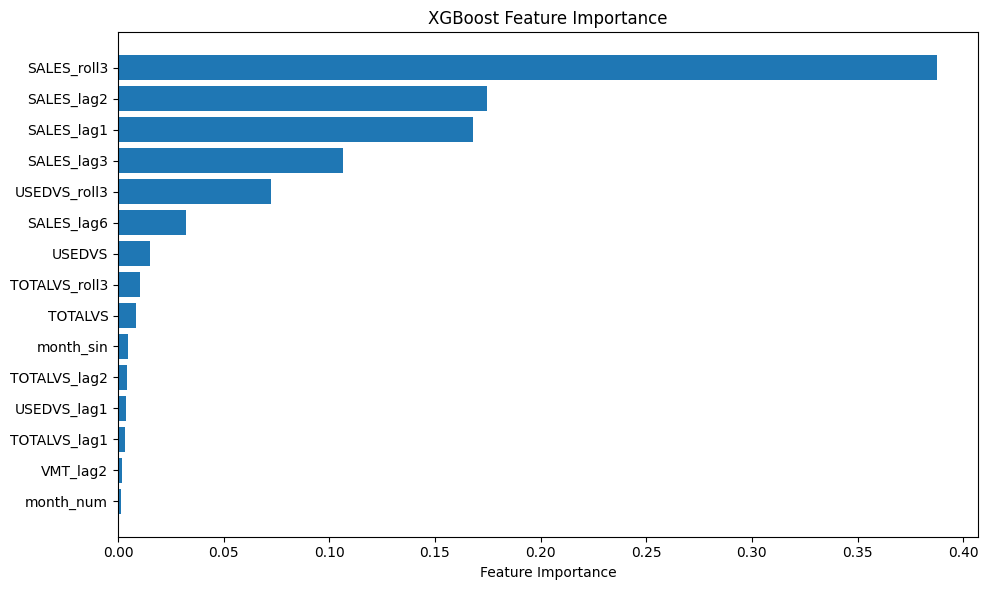


=== Final df with historical + forecasted values ===
        ds        SALES
2025-01-01 52981.000000
2025-02-01 52610.000000
2025-03-01 51135.000000
2025-04-01 50785.000000
2025-05-01 49778.000000
2025-06-01 50992.859375
2025-07-01 52607.683594
2025-08-01 54611.167969

=== Best Parameters Found ===
{'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1}


: 

In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'SALES'
EXOG_COLS = ['VMT', 'USEDVS', 'TOTALVS']
df = df_full  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=600,
    max_depth=2,
    learning_rate=0.05,
    subsample=1,
    colsample_bytree=0.6,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

#

importances = model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[sorted_idx][:top_n][::-1])
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
df.to_pickle("GasD.pkl")
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))


#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""